In [165]:
from pathlib import Path
import imghdr
import os

data_dir = "hair_types"
image_extensions = [".png", ".jpg"] # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)

# Hyperparameters

In [166]:
epochs = 20
img_dimensions = 256
batch_size = 16
learning_rate = 1e-3

# Data Preprocessing

In [167]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = (img_dimensions, img_dimensions)

datagen_train = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2,
    #rotation_range=5,
    #width_shift_range=0.05,
    #height_shift_range=0.05,
    #shear_range=0.05,
    #zoom_range=0.05,
    #horizontal_flip=True,
    #vertical_flip=True
    )

train_ds = datagen_train.flow_from_directory(
    data_dir,
    seed=1337,
    target_size=image_size,
    batch_size=batch_size, 
    shuffle=True,
    subset='training')

val_ds = datagen_train.flow_from_directory(
    data_dir,
    seed=1337,
    target_size=image_size,
    batch_size=batch_size, 
    shuffle=True,
    subset='validation')

Found 785 images belonging to 3 classes.
Found 195 images belonging to 3 classes.


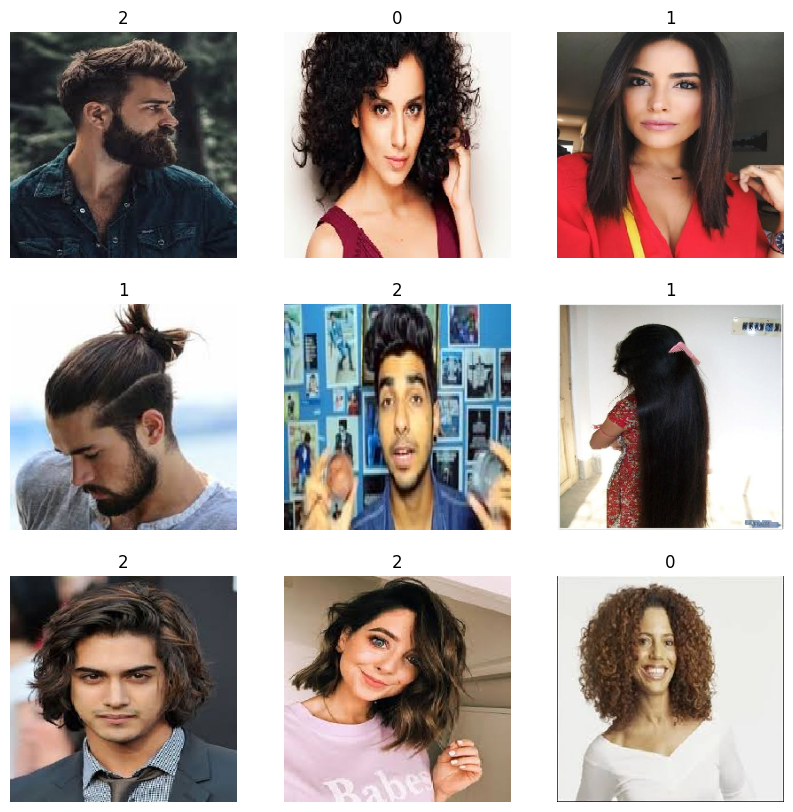

In [168]:
import matplotlib.pyplot as plt
import numpy as np

images, labels = next(train_ds)
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))
    plt.title(np.argmax(labels[i]))
    plt.axis("off")

plt.show()

# Model Architecture

In [169]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(keras.Input(shape=image_size + (3,)))
model.add(layers.Rescaling(1.0 / 255))

model.add(layers.Conv2D(filters=16, kernel_size=3, strides=2, padding='valid', dilation_rate=1))
model.add(layers.BatchNormalization(synchronized=True))
model.add(layers.Activation("relu"))
model.add(layers.MaxPooling2D(pool_size=2, strides=2))

model.add(layers.Conv2D(filters=32, kernel_size=15, strides=2, padding='valid', dilation_rate=1))
model.add(layers.Activation("relu"))
model.add(layers.MaxPooling2D(pool_size=2, strides=2))

model.add(layers.Conv2D(filters=64, kernel_size=5, strides=1, padding='valid', dilation_rate=1))
model.add(layers.Activation("relu"))

model.add(layers.Conv2D(filters=128, kernel_size=5, strides=1, padding='valid', dilation_rate=1))
model.add(layers.Activation("relu"))

# Flatten
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Flatten())

model.add(layers.Dense(32))
model.add(layers.Activation("relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3))
model.add(layers.Activation("softmax"))

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_20 (Rescaling)    (None, 256, 256, 3)       0         
                                                                 
 conv2d_77 (Conv2D)          (None, 127, 127, 16)      448       
                                                                 
 batch_normalization_18 (Ba  (None, 127, 127, 16)      64        
 tchNormalization)                                               
                                                                 
 activation_117 (Activation  (None, 127, 127, 16)      0         
 )                                                               
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 63, 63, 16)        0         
 ng2D)                                                           
                                                     

# Training

In [170]:
def learning_rate_schedule(epoch):
    initial_lr = learning_rate
    drop = 0.1
    epochs_drop = 12
    lr = initial_lr * np.power(drop, np.floor((1 + epoch) / epochs_drop))
    return lr

history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[  tf.keras.callbacks.EarlyStopping(patience=5),
                                                                                  tf.keras.callbacks.LearningRateScheduler(learning_rate_schedule)
                                                                                ])

Epoch 1/20
50/50 [==============================] - 22s 407ms/step - loss: 1.1141 - accuracy: 0.3669 - val_loss: 1.0935 - val_accuracy: 0.3179 - lr: 0.0010
Epoch 2/20
50/50 [==============================] - 20s 393ms/step - loss: 1.0802 - accuracy: 0.4064 - val_loss: 1.0938 - val_accuracy: 0.3744 - lr: 0.0010
Epoch 3/20
50/50 [==============================] - 19s 381ms/step - loss: 1.0242 - accuracy: 0.4828 - val_loss: 1.0637 - val_accuracy: 0.5179 - lr: 0.0010
Epoch 4/20
50/50 [==============================] - 19s 374ms/step - loss: 0.9806 - accuracy: 0.4854 - val_loss: 0.9882 - val_accuracy: 0.5026 - lr: 0.0010
Epoch 5/20
50/50 [==============================] - 20s 410ms/step - loss: 0.9349 - accuracy: 0.5248 - val_loss: 0.9688 - val_accuracy: 0.5487 - lr: 0.0010
Epoch 6/20
50/50 [==============================] - 19s 388ms/step - loss: 0.9101 - accuracy: 0.5299 - val_loss: 0.9973 - val_accuracy: 0.5128 - lr: 0.0010
Epoch 7/20
50/50 [==============================] - 21s 413ms/st

In [171]:
img = keras.preprocessing.image.load_img(
    "hair_types/Curly_Hair/02dac897d1dec9ba8c057a11d041ada8--layered-natural-hair-natural-black-hairstyles.jpg",
    target_size=image_size)

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create batch axis
predictions = model.predict(img_array)

print("This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavy hair."% tuple(predictions[0]))

1/1 [==============================] - 0s 270ms/step
This image is 0.98 percent curly hair, 0.01 percent straight hair, and 0.00 percent wavy hair.


# Visualizations

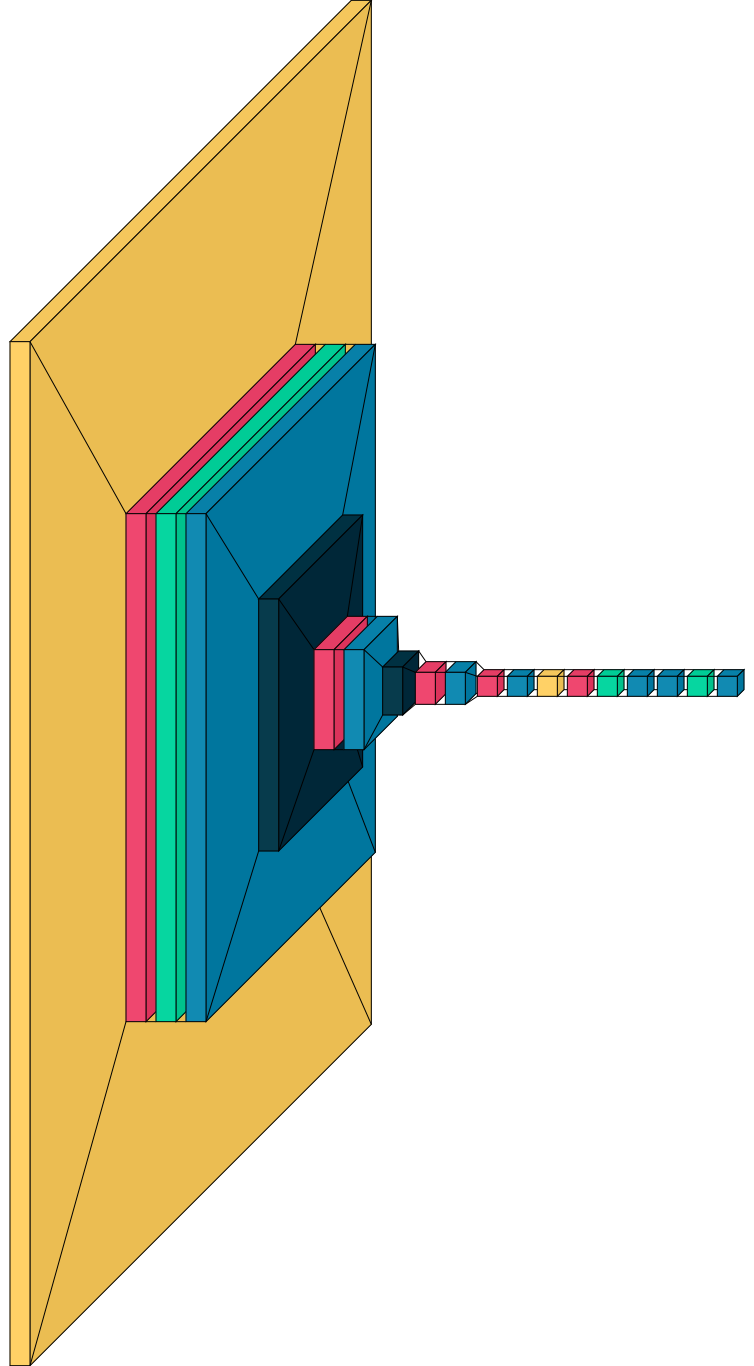

In [172]:
# !pip install visualkeras
import visualkeras

visualkeras.layered_view(model)

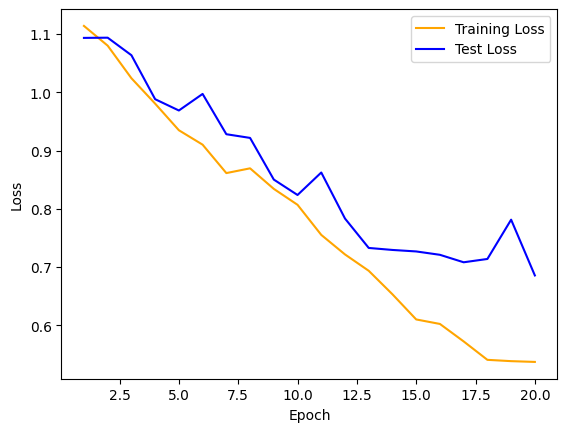

In [173]:
training_loss = history.history['loss']
test_loss = history.history['val_loss']

epoch_count = range(1, len(training_loss) + 1)

plt.plot(epoch_count, training_loss, color="orange")
plt.plot(epoch_count, test_loss, color="blue")
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

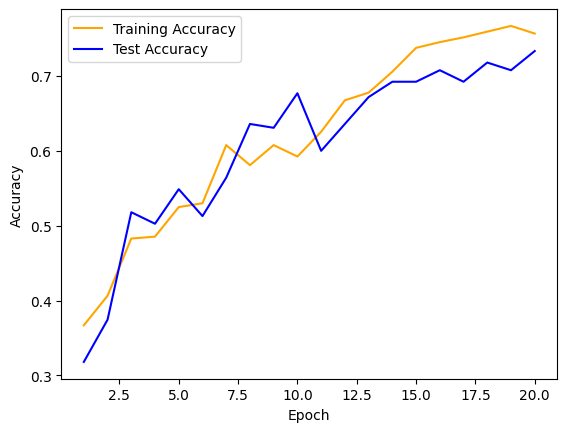

In [174]:
training_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']

epoch_count = range(1, len(training_loss) + 1)

plt.plot(epoch_count, training_acc, color="orange")
plt.plot(epoch_count, test_acc, color="blue")
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();